Optimal Path (states as ((x1,y1), (x2,y2))):
((0, 0), (0, 0))
((0, 1), (1, 0))
((0, 2), (1, 1))
((1, 2), (2, 1))
((1, 3), (2, 2))
((1, 2), (3, 2))

Optimal Disk Positions (At terminal state): ((1, 2), (3, 2))


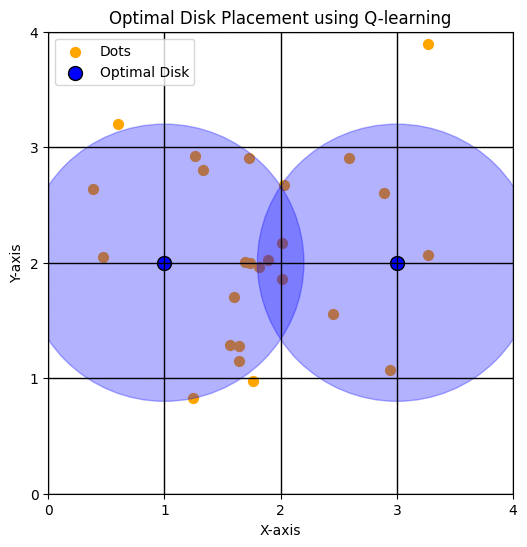

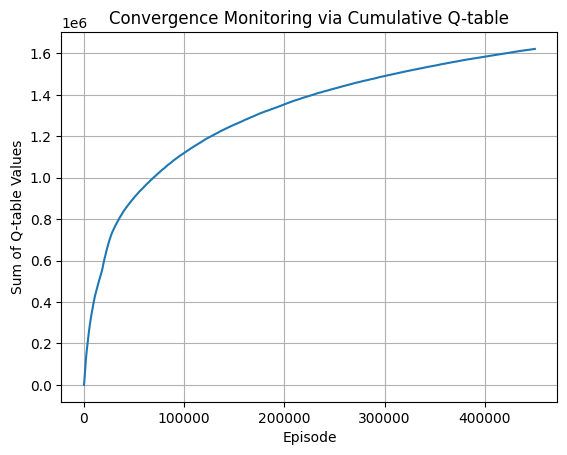

In [2]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

disk_radius = 1.2

# Define the dot coordinates (Synthetic Data)
dots = np.array([
  [1.73, 2.91],
  [1.33, 2.80],
  [1.25, 0.83],
  [2.59, 2.91],
  [1.64, 1.15],
  [2.01, 2.17],
  [1.60, 1.70],
  [0.47, 2.05],
  [1.81, 1.96],
  [1.64, 1.28],
  [2.01, 1.86],
  [2.94, 1.07],
  [1.26, 2.92],
  [1.56, 1.29],
  [2.03, 2.67],
  [1.89, 2.02],
  [1.76, 0.98],
  [1.74, 2.00],
  [1.69, 2.01],
  [2.45, 1.56],
  [0.39, 2.64],
  [3.27, 2.07],
  [3.27, 3.89],
  [2.89, 2.60],
  [0.60, 3.20]
])

# Grid settings: (0,1,2,3,4) for both x and y.
grid_positions = [(x, y) for x in range(5) for y in range(5)]  # 25 positions

# Valid actions for a single disk (0+x, 1+y) - Action Space
moves = {
    'up':    (0,  1),
    'down':  (0, -1),
    'left':  (-1, 0),
    'right': (1,  0),
    'stay':  (0,  0)
}

# For two disks, the joint action is a pair of moves (one for each disk).
joint_actions = []
for move1 in moves.values():
  for move2 in moves.values():
    joint_actions.append( (move1, move2) )
num_joint_actions = len(joint_actions) # 25 total action = 5 * 5

# Create a mapping from state (positions for disk1 and disk2) to an index for our Q-table.
# A state is defined as ((x1,y1), (x2,y2))
state_to_index = {}
state_index = 0
for pos1 in grid_positions:
  for pos2 in grid_positions:
    state = (pos1, pos2)
    state_to_index[state] = state_index
    state_index += 1
num_states = state_index  # 25 * 25 = 625 states

# Initialize the Q-table: a numpy array of shape (num_states, num_joint_actions)
Q_table = np.zeros((num_states, num_joint_actions)) #625 x 25 = 15,625

# Function to compute reward given a state.
def compute_reward(state):
  pos1, pos2 = state
  covered = set()
  # For each dot, if it is within disk_radius of either disk center, mark it covered.
  for i, dot in enumerate(dots):
    dx1 = dot[0] - pos1[0]
    dy1 = dot[1] - pos1[1]
    d1 = math.sqrt(dx1**2 + dy1**2)

    dx2 = dot[0] - pos2[0]
    dy2 = dot[1] - pos2[1]
    d2 = math.sqrt(dx2**2 + dy2**2)

    if d1 <= disk_radius or d2 <= disk_radius:
      covered.add(i)
  return len(covered)

# Function to get the next state given current state and a joint action.
def get_next_state(state, joint_action):
  pos1, pos2 = state
  (dx1, dy1), (dx2, dy2) = joint_action
  # making sure they go outside the 4x4 grid
  new_x1 = pos1[0] + dx1
  new_y1 = pos1[1] + dy1
  new_x2 = pos2[0] + dx2
  new_y2 = pos2[1] + dy2

  if new_x1 < 0 or new_x1 > 4 or new_y1 < 0 or new_y1 > 4:
    new_pos1 = pos1
  else:
    new_pos1 = (new_x1, new_y1)

  if new_x2 < 0 or new_x2 > 4 or new_y2 < 0 or new_y2 > 4:
    new_pos2 = pos2
  else:
    new_pos2 = (new_x2, new_y2)

  return (new_pos1, new_pos2)

# Q-learning parameters
alpha = 0.1          # learning rate
gamma = 0.9          # discount factor # 0.99
epsilon = 0.2        # exploration rate
num_episodes = 450000  # total training episodes
max_steps = 50       # maximum steps per episode

# Predefine a starting state
start_state = ((0, 0), (0, 0)) #starting at the origin

conv = []

# Training loop for Q-learning.
for episode in range(num_episodes):
  state = start_state
  state_idx = state_to_index[state]

  for step in range(max_steps):
    if random.uniform(0, 1) < epsilon:
      action_idx = random.randint(0, num_joint_actions - 1)
    else:
      action_idx = np.argmax(Q_table[state_idx])

    action = joint_actions[action_idx]
    next_state = get_next_state(state, action)
    next_state_idx = state_to_index[next_state]

    reward = compute_reward(next_state)

    Q_table[state_idx, action_idx] = Q_table[state_idx, action_idx] + alpha * (
      reward + gamma * np.max(Q_table[next_state_idx]) - Q_table[state_idx, action_idx]
    )

    state = next_state
    state_idx = next_state_idx

  conv.append((np.sum(Q_table)))

# Optimal state would be where best action is (stay, stay)
def optimal_path(initial_state, max_steps=20):
  state = initial_state
  path = [state]
  for i in range(max_steps):
    state_idx = state_to_index[state]
    best_action_idx = np.argmax(Q_table[state_idx])
    best_action = joint_actions[best_action_idx]

    if best_action == (moves['stay'], moves['stay']): #if (stay, stay) is the best action, loop stops.
      break
    state = get_next_state(state, best_action)
    path.append(state)
  return path

# Retrieve the optimal path starting from the predefined start state
optimal_path = optimal_path(start_state)
best_positions = optimal_path[-1]  # Last index

print("Optimal Path (states as ((x1,y1), (x2,y2))):")
for s in optimal_path:
  print(s)

print("\nOptimal Disk Positions (At terminal state):", best_positions)

# Visualization of the grid, dots, and optimal disk positions.
fig, ax = plt.subplots(figsize=(6, 6)) # 6in by 6in

for i in range(5):
  ax.plot([i, i], [0, 4], 'k-', linewidth=1)
  ax.plot([0, 4], [i, i], 'k-', linewidth=1)

ax.scatter(dots[:, 0], dots[:, 1], color='orange', s=50, label='Dots')

# Plot optimal disk positions with circles indicating coverage.
for pos in best_positions:
    circle = plt.Circle(pos, disk_radius, color='blue', alpha=0.3)
    ax.add_patch(circle)
    ax.scatter(pos[0], pos[1], color='blue', s=100, edgecolors='black',
               label='Optimal Disk' if pos == best_positions[0] else "")

ax.set_xlim(0, 4)
ax.set_ylim(0, 4)
ax.set_xticks(range(5))
ax.set_yticks(range(5))
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_title("Optimal Disk Placement using Q-learning")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.show()

plt.plot(conv)
plt.xlabel("Episode")
plt.ylabel("Sum of Q-table Values")
plt.title("Convergence Monitoring via Cumulative Q-table")
plt.grid(True)
plt.show()